In [3]:
import glob
import cv2
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=np.inf)
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt

# Binary Masks

In [341]:
images = glob.glob("./font/*/*/*.png"); # array of image file paths (features)

for file in images:
    # loading image as a grayscale
    image = cv2.imread(file,  cv2.IMREAD_GRAYSCALE);
    normalized_image = image / 255.0 # normalizing

    # handwriting extraction and obtaining a binary mask
    _, binary_mask = cv2.threshold(normalized_image, 0.7, 1, cv2.THRESH_BINARY_INV)
    binary_mask_path = f'{file[0:-4]}_binary_mask.png';
    #print(binary_mask_path)
    if not cv2.imwrite(binary_mask_path, (binary_mask * 255).astype(np.uint8)):
        raise Exception("Could not write image")


In [342]:
binary_masks = glob.glob("./font/*/*/*_binary_mask.png");

In [357]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = float(image) / 255.0
    return image

# Function to load and preprocess binary masks
def load_and_preprocess_mask(mask_path):
    # Load the binary mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [224,224])
    mask = float(mask) / 255.0
    return mask

In [358]:
#image_dataset = tf.data.Dataset.from_tensor_slices(images);
mask_dataset = tf.data.Dataset.from_tensor_slices(binary_masks);

# Apply the preprocessing functions to the datasets
#image_dataset = image_dataset.map(load_and_preprocess_image)
mask_dataset = mask_dataset.map(load_and_preprocess_mask)
mask_dataset = mask_dataset.cache();

#combined_dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

# Print the first few elements of the combined dataset
#for image, mask in combined_dataset.take(3):
 #   print("Image shape:", image.shape)
  #  print("Mask shape:", mask.shape)

In [359]:
len(mask_dataset)

2053

In [360]:
iterator = tf.compat.v1.data.make_one_shot_iterator(mask_dataset)

2024-01-23 16:33:02.133671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2053]
	 [[{{node Placeholder/_0}}]]


(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


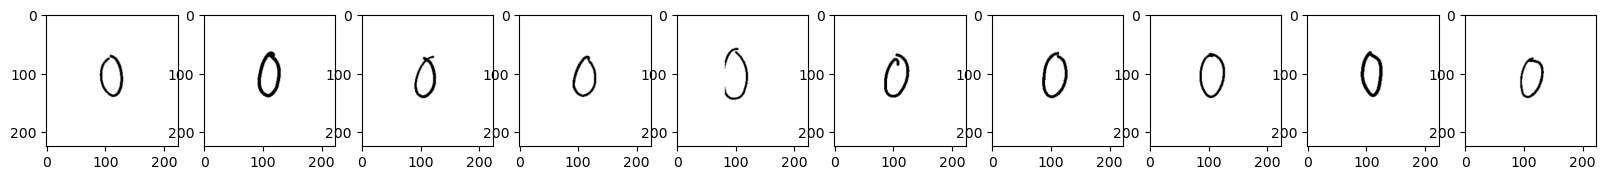

In [364]:
fig, ax = plt.subplots(1, 10, figsize=(20,20))

for idx in range(10):
    mask = iterator.next()
    print(mask.shape)
    ax[idx].imshow(mask, cmap="gray_r")

In [362]:
# Assuming target_height, target_width, channels are the dimensions of your images
target_height, target_width, channels = 224, 224, 1
noise_dim = 200
# Generator Model
def build_generator(noise_dim):
    noise_input = layers.Input(shape=(noise_dim,))
    mask_input = layers.Input(shape = (224,224,1))
    
    # Reshape noise vector to match the dimensions of the binary mask
    reshaped_noise = layers.Reshape((1, 1, noise_dim))(noise_input)
    repeated_noise = layers.UpSampling2D(size=(224, 224))(reshaped_noise)

    # Concatenate noise vector and mask
    combined_input = layers.Concatenate(axis=-1)([repeated_noise, mask_input])

    model = models.Sequential()
    
    model.add(layers.Dense(7 * 7 * 128))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.UpSampling2D());
    model.add(layers.Conv2D(128, 5, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.UpSampling2D());
    model.add(layers.Conv2D(128, 5, padding="same"))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 4, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2D(128, 4, padding="same"))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.UpSampling2D());
    model.add(layers.Conv2D(128, 4, padding="same"))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.UpSampling2D());
    model.add(layers.Conv2D(128, 4, padding="same"))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 3, padding="same"))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 3, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.UpSampling2D());
    model.add(layers.Conv2D(128, 3, padding="same"))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 3, padding="same"))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(1, 3, padding="same", activation="sigmoid"))

    # Combine the noise and mask inputs with the generator model
    generated_image = model(combined_input)

    # Model with both noise and mask inputs
    generator = models.Model(inputs=[noise_input, mask_input], outputs=generated_image)

    return generator

# Discriminator Model
def build_discriminator(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [363]:
# Build and compile generator and discriminator
generator = build_generator(noise_dim)
#discriminator = build_discriminator((target_height, target_width, channels * 2))  # Concatenate image and mask
#cgan = build_conditional_gan(generator, discriminator, noise_dim)

# Print model summaries
generator.summary()
#discriminator.summary()
#cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 reshape_47 (Reshape)           (None, 1, 1, 200)    0           ['input_27[0][0]']               
                                                                                                  
 up_sampling2d_158 (UpSampling2  (None, 224, 224, 20  0          ['reshape_47[0][0]']             
 D)                             0)                                                                
                                                                                                  
 input_28 (InputLayer)          [(None, 224, 224, 1  0           []                         

In [298]:
pred_img = generator.predict(np.random.randn(4, noise_dim, 1))
pred_img

1/1 [==============================] - 2s 2s/step


array([[[[0.5001589 ],
         [0.50054204],
         [0.50057316],
         [0.50066406],
         [0.5005635 ],
         [0.5007477 ],
         [0.50084823],
         [0.5007583 ],
         [0.5008525 ],
         [0.500909  ],
         [0.50094587],
         [0.50105274],
         [0.5010683 ],
         [0.50093484],
         [0.50095135],
         [0.5009899 ],
         [0.5010851 ],
         [0.5010755 ],
         [0.50116354],
         [0.50122917],
         [0.501256  ],
         [0.50106317],
         [0.5012598 ],
         [0.5014433 ],
         [0.50146925],
         [0.5015977 ],
         [0.50160116],
         [0.50164753],
         [0.50172395],
         [0.50149775],
         [0.5014963 ],
         [0.501725  ],
         [0.5017075 ],
         [0.5018834 ],
         [0.5019637 ],
         [0.50192976],
         [0.50187546],
         [0.50178194],
         [0.5016356 ],
         [0.5016608 ],
         [0.50174654],
         [0.50172263],
         [0.5018424 ],
         [0

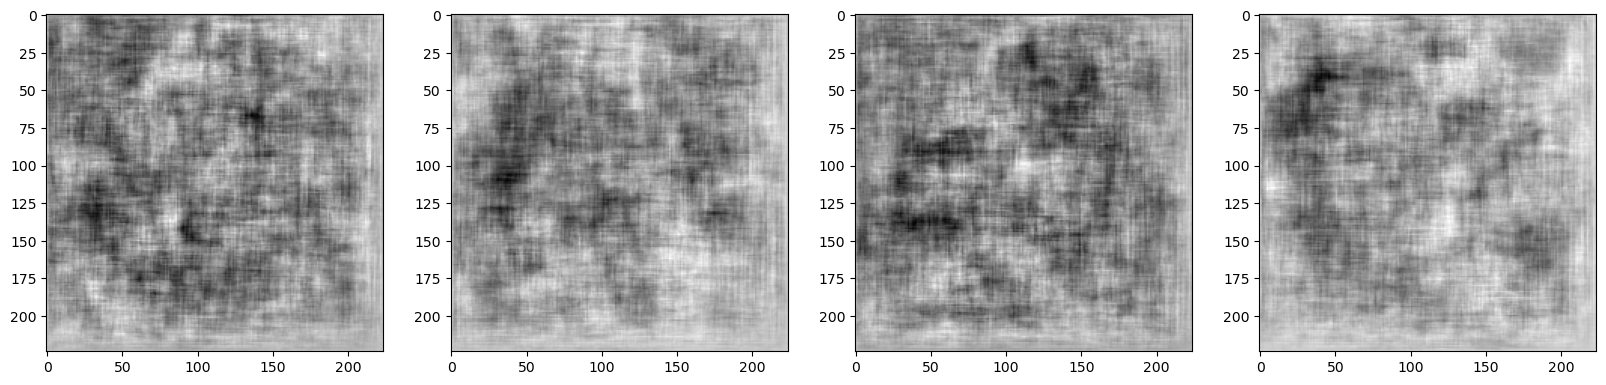

In [365]:
pred_img.shape

fig, ax = plt.subplots(1, 4, figsize=(20,20))

for idx, img in enumerate(pred_img):
    ax[idx].imshow(np.squeeze(img), cmap="gray_r")